In [2]:
import os
import time
from PIL import Image
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"

In [3]:
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"

**Defining Helper Functions**

In [4]:
def preprocess_image(image_path):
  """ Loads image from path and preprocesses to make it model ready
      Args:
        image_path: Path to the image file
  """
  hr_image = tf.image.decode_image(tf.io.read_file(image_path))
  # If PNG, remove the alpha channel. The model only supports
  # images with 3 color channels.
  if hr_image.shape[-1] == 4:
    hr_image = hr_image[...,:-1]
  hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
  hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
  hr_image = tf.cast(hr_image, tf.float32)
  return tf.expand_dims(hr_image, 0)

def save_image(image, filename):
  """
    Saves unscaled Tensor Images.
    Args:
      image: 3D image tensor. [height, width, channels]
      filename: Name of the file to save.
  """
  if not isinstance(image, Image.Image):
    image = tf.clip_by_value(image, 0, 255)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  image.save("%s.jpg" % filename)
  print("Saved as %s.jpg" % filename)

In [5]:
%matplotlib inline
def plot_image(image, title=""):
  """
    Plots images from image tensors.
    Args:
      image: 3D image tensor. [height, width, channels].
      title: Title to display in the plot.
  """
  image = np.asarray(image)
  image = tf.clip_by_value(image, 0, 255)
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  plt.imshow(image)
  plt.axis("off")
  plt.title(title)

In [6]:
model = hub.load(SAVED_MODEL_PATH)

Downloaded https://tfhub.dev/captain-pool/esrgan-tf2/1, Total size: 20.60MB



In [7]:
# Defining helper functions
def downscale_image(image):
  """
      Scales down images using bicubic downsampling.
      Args:
          image: 3D or 4D tensor of preprocessed image
  """
  image_size = []
  if len(image.shape) == 3:
    image_size = [image.shape[1], image.shape[0]]
  else:
    raise ValueError("Dimension mismatch. Can work only on single image.")

  image = tf.squeeze(
      tf.cast(
          tf.clip_by_value(image, 0, 255), tf.uint8))

  lr_image = np.asarray(
    Image.fromarray(image.numpy())
    .resize([image_size[0] // 4, image_size[1] // 4],
              Image.BICUBIC))

  lr_image = tf.expand_dims(lr_image, 0)
  lr_image = tf.cast(lr_image, tf.float32)
  return lr_image

In [8]:
model = hub.load(SAVED_MODEL_PATH)

### Image Fusion

In [9]:
vsrnet_test_lr = './vsrnet_test_lr.h5'
vsrnet_test_hr = './vsrnet_test_hr.h5'
vsrnet_test_lrx = './vsrnet_test_lrx.h5'

!wget https://www.dropbox.com/sh/1jz9zeer9wxetx2/AAAf3gSWeQAebAunmpALVCu_a/uf_4/test/LR_Bic_MC/scene_25.h5 -O vsrnet_test_lr
!wget https://www.dropbox.com/sh/1jz9zeer9wxetx2/AADAUSF400EgaM3pZZS0hoXta/uf_4/test/HR/scene_25.h5 -O vsrnet_test_hr
!wget https://www.dropbox.com/sh/1jz9zeer9wxetx2/AACZFsZ00CMVjWCAEmRle79ha/uf_4/test/LR/scene_25.h5 -O vsrnet_test_lrx

--2023-05-15 00:30:52--  https://www.dropbox.com/sh/1jz9zeer9wxetx2/AAAf3gSWeQAebAunmpALVCu_a/uf_4/test/LR_Bic_MC/scene_25.h5
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /sh/raw/1jz9zeer9wxetx2/AAAf3gSWeQAebAunmpALVCu_a/uf_4/test/LR_Bic_MC/scene_25.h5 [following]
--2023-05-15 00:30:52--  https://www.dropbox.com/sh/raw/1jz9zeer9wxetx2/AAAf3gSWeQAebAunmpALVCu_a/uf_4/test/LR_Bic_MC/scene_25.h5
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc13dddfd67f20f2ce2a969e4b9f.dl.dropboxusercontent.com/cd/0/inline/B8ECJlfGIgFnGa03z7BMBSnVJb_kLg8203FEesRUntkYiIjKiJnTZ15NModbLeyIIV98eO6bjMyZ4PVg4JCWA9LruUSd4qO9LXMyq2QgWl4PvnVK9cwT3t0T7nWYAfQprmPzMcjnGRZTjgIyXn1lion5xlStgMYBPFxORW1ybyg0Tg/file# [following]
--2023-05-15 00:30:53--  https://uc13dddfd

In [10]:
def fuseCoeff(cooef1, cooef2, method):

    if (method == 'mean'):
        cooef = (cooef1 + cooef2) / 2
    elif (method == 'min'):
        cooef = np.minimum(cooef1,cooef2)
    elif (method == 'max'):
        cooef = np.maximum(cooef1,cooef2)
    else:
        cooef = []

    return cooef

def fusion(I1,I2,FUSION_METHOD = 'mean'):

# Read the two image
# I1 = cv2.imread('i1.bmp',0)
# I2 = cv2.imread('i2.jpg',0)

# We need to have both images the same size
# I2 = cv2.resize(I2,I1.shape) # I do this just because i used two random images

## Fusion algo

    # First: Do wavelet transform on each image
    wavelet = 'db1'
    cooef1 = pywt.wavedec2(I1[:,:], wavelet)
    cooef2 = pywt.wavedec2(I2[:,:], wavelet)

    # Second: for each level in both image do the fusion according to the desire option
    fusedCooef = []
    for i in range(len(cooef1)-1):

        # The first values in each decomposition is the apprximation values of the top level
        if(i == 0):

            fusedCooef.append(fuseCoeff(cooef1[0],cooef2[0],FUSION_METHOD))

        else:

            # For the rest of the levels we have tupels with 3 coeeficents
            c1 = fuseCoeff(cooef1[i][0],cooef2[i][0],FUSION_METHOD)
            c2 = fuseCoeff(cooef1[i][1], cooef2[i][1], FUSION_METHOD)
            c3 = fuseCoeff(cooef1[i][2], cooef2[i][2], FUSION_METHOD)

            fusedCooef.append((c1,c2,c3))

    # Third: After we fused the cooefficent we need to transform back to get the image
    fusedImage = pywt.waverec2(fusedCooef, wavelet)
    fusedImage = cv2.resize(fusedImage, (fusedImage.shape[1]*2,fusedImage.shape[0]*2), interpolation=cv2.INTER_CUBIC)
    
    # Forth: normmalize values to be in uint8
    fusedImage = np.multiply(np.divide(fusedImage - np.min(fusedImage),(np.max(fusedImage) - np.min(fusedImage))),255)
    fusedImage = fusedImage.astype(np.uint8)

    return fusedImage

# # Fith: Show image
# cv2.imshow("win",fusedImage)

In [39]:
import random 

def channelTransform(ch1,ch2, shape):
    cooef1 = pywt.dwt2(ch1, 'db5', mode = 'periodization')
    cooef2 = pywt.dwt2(ch2, 'db5', mode = 'periodization')
    cA1, (cH1, cV1, cD1) = cooef1
    cA2, (cH2, cV2, cD2) = cooef2

    # cA = (cA1+cA2)/2
    # cH = (cH1 +cH2)/2
    # cV = (cV1+cV2)/2
    # cD = (cD1+cD2)/2
    cA = (0.9*cA1+0.1*cA2)
    cH = (0.9*cH1+0.1*cH2)
    cV = (0.9*cV1+0.1*cV2)
    cD = (0.9*cD1+0.1*cD2)
    fincoC = cA, (cH,cV,cD)
    outImageC = pywt.idwt2(fincoC, 'db5', mode = 'periodization')
    outImageC = cv2.resize(outImageC,(shape[0],shape[1])) 
    return outImageC

def fusion(img1, img2, FUSION_METHOD = 'mean'):
    # Params
    # FUSION_METHOD = 'mean' # Can be 'min' || 'max || anything you choose according theory

    I1 = img1
    I2 = img2

    # Read the two image
    # I1 = cv2.imread(img1)
    # I2 = cv2.imread(img2)

    # Resizing image if both are in different shapes
    # I2 = cv2.resize(I2,(I1.shape[1],I1.shape[0])) 
    
    # print (I1.shape)
    # print (I2.shape)
    ## Separating channels
    iR1 = I1.copy()
    iR1[:,:,1] = iR1[:,:,2] = 0
    iR2 = I2.copy()
    iR2[:,:,1] = iR2[:,:,2] = 0

    iG1 = I1.copy()
    iG1[:,:,0] = iG1[:,:,2] = 0
    iG2 = I2.copy()
    iG2[:,:,0] = iG2[:,:,2] = 0

    iB1 = I1.copy()
    iB1[:,:,0] = iB1[:,:,1] = 0
    iB2 = I2.copy()
    iB2[:,:,0] = iB2[:,:,1] = 0

    shape = (I1.shape[1], I1.shape[0])
    # Wavelet transformation on red channel
    outImageR = channelTransform(iR1, iR2, shape)
    outImageG = channelTransform(iG1, iG2, shape)
    outImageB = channelTransform(iB1, iB2, shape)

    outImage = I1.copy()
    outImage[:,:,0] = outImage[:,:,1] = outImage[:,:,2] = 0
    outImage[:,:,0] = outImageR[:,:,0]
    outImage[:,:,1] = outImageG[:,:,1]
    outImage[:,:,2] = outImageB[:,:,2] 

    outImage = np.multiply(np.divide(outImage - np.min(outImage),(np.max(outImage) - np.min(outImage))),255)
    outImage = outImage.astype(np.uint8)

    # x = random.randint(1000, 2000)
    # loc = 'demo/out'+str(x)+'.jpg'
    # cv2.imwrite(loc,outImage)

    return outImage

In [16]:
import numpy
import math

def psnr(img1, img2):
    mse = numpy.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

In [17]:
from scipy.ndimage import gaussian_filter

from numpy.lib.stride_tricks import as_strided as ast

"""
Hat tip: http://stackoverflow.com/a/5078155/1828289
"""
def block_view(A, block=(3, 3)):
    """Provide a 2D block view to 2D array. No error checking made.
    Therefore meaningful (as implemented) only for blocks strictly
    compatible with the shape of A."""
    # simple shape and strides computations may seem at first strange
    # unless one is able to recognize the 'tuple additions' involved ;-)
    shape = (A.shape[0]// block[0], A.shape[1]// block[1])+ block
    strides = (block[0]* A.strides[0], block[1]* A.strides[1])+ A.strides
    return ast(A, shape= shape, strides= strides)


def ssim(img1, img2, C1=0.01**2, C2=0.03**2):

    bimg1 = block_view(img1, (4,4))
    bimg2 = block_view(img2, (4,4))
    s1  = numpy.sum(bimg1, (-1, -2))
    s2  = numpy.sum(bimg2, (-1, -2))
    ss  = numpy.sum(bimg1*bimg1, (-1, -2)) + numpy.sum(bimg2*bimg2, (-1, -2))
    s12 = numpy.sum(bimg1*bimg2, (-1, -2))

    vari = ss - s1*s1 - s2*s2
    covar = s12 - s1*s2

    ssim_map =  (2*s1*s2 + C1) * (2*covar + C2) / ((s1*s1 + s2*s2 + C1) * (vari + C2))
    return numpy.mean(ssim_map)

# FIXME there seems to be a problem with this code
def ssim_exact(img1, img2, sd=1.5, C1=0.01**2, C2=0.03**2):

    mu1 = gaussian_filter(img1, sd)
    mu2 = gaussian_filter(img2, sd)
    mu1_sq = mu1 * mu1
    mu2_sq = mu2 * mu2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = gaussian_filter(img1 * img1, sd) - mu1_sq
    sigma2_sq = gaussian_filter(img2 * img2, sd) - mu2_sq
    sigma12 = gaussian_filter(img1 * img2, sd) - mu1_mu2

    ssim_num = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2))

    ssim_den = ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))

    ssim_map = ssim_num / ssim_den
    return numpy.mean(ssim_map)

In [21]:
!pip install pytorch-msssim
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


  7%|▋         | 1/14 [00:22<04:46, 22.03s/it]

(1, 1080, 1920, 3)
(1080, 1920, 3)
tf.Tensor([33.98456], shape=(1,), dtype=float32)


 14%|█▍        | 2/14 [00:43<04:22, 21.86s/it]

(1, 1080, 1920, 3)
(1080, 1920, 3)
tf.Tensor([32.6175], shape=(1,), dtype=float32)


 21%|██▏       | 3/14 [01:06<04:03, 22.10s/it]

(1, 1080, 1920, 3)
(1080, 1920, 3)
tf.Tensor([33.7709], shape=(1,), dtype=float32)


 29%|██▊       | 4/14 [01:28<03:42, 22.25s/it]

(1, 1080, 1920, 3)
(1080, 1920, 3)
tf.Tensor([32.799034], shape=(1,), dtype=float32)


 36%|███▌      | 5/14 [01:50<03:19, 22.16s/it]

(1, 1080, 1920, 3)
(1080, 1920, 3)
tf.Tensor([34.236652], shape=(1,), dtype=float32)


 43%|████▎     | 6/14 [02:12<02:56, 22.07s/it]

(1, 1080, 1920, 3)
(1080, 1920, 3)
tf.Tensor([31.894794], shape=(1,), dtype=float32)


 50%|█████     | 7/14 [02:34<02:34, 22.02s/it]

(1, 1080, 1920, 3)
(1080, 1920, 3)
tf.Tensor([30.811983], shape=(1,), dtype=float32)


 57%|█████▋    | 8/14 [02:57<02:13, 22.23s/it]

(1, 1080, 1920, 3)
(1080, 1920, 3)
tf.Tensor([32.689888], shape=(1,), dtype=float32)


 64%|██████▍   | 9/14 [03:19<01:51, 22.34s/it]

(1, 1080, 1920, 3)
(1080, 1920, 3)
tf.Tensor([31.61588], shape=(1,), dtype=float32)


 71%|███████▏  | 10/14 [03:41<01:29, 22.28s/it]

(1, 1080, 1920, 3)
(1080, 1920, 3)
tf.Tensor([33.01842], shape=(1,), dtype=float32)


<ipython-input-39-cd131d4034dd>:66: RuntimeWarning: invalid value encountered in true_divide
  outImage = np.multiply(np.divide(outImage - np.min(outImage),(np.max(outImage) - np.min(outImage))),255)
 79%|███████▊  | 11/14 [04:03<01:06, 22.14s/it]

(1, 1080, 1920, 3)
(1080, 1920, 3)
tf.Tensor([inf], shape=(1,), dtype=float32)


 86%|████████▌ | 12/14 [04:26<00:44, 22.26s/it]

(1, 1080, 1920, 3)
(1080, 1920, 3)
tf.Tensor([inf], shape=(1,), dtype=float32)


 93%|█████████▎| 13/14 [04:48<00:22, 22.20s/it]

(1, 1080, 1920, 3)
(1080, 1920, 3)
tf.Tensor([inf], shape=(1,), dtype=float32)


100%|██████████| 14/14 [05:10<00:00, 22.17s/it]

(1, 1080, 1920, 3)
(1080, 1920, 3)
tf.Tensor([inf], shape=(1,), dtype=float32)
===> Test on Video Idx: 0 Complete: Model PSNR: 32.7440 dB, Model SSIM: 1.0000 , Average time: 17767.6515


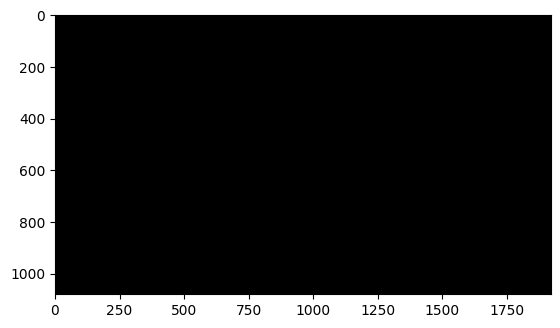

In [48]:
from tqdm import tqdm
import cv2
import h5py
import pywt
from skimage.metrics import structural_similarity

video_idx = 0
#   Read h5 file
LR_h5_file = h5py.File('./vsrnet_test_lrx', 'r')
LR_h5_data = LR_h5_file['data']
LR_Bic_MC_h5_file = h5py.File('./vsrnet_test_lr', 'r')
LR_Bic_MC_h5_data = LR_Bic_MC_h5_file['data']
HR_h5_file = h5py.File('./vsrnet_test_hr', 'r')
HR_h5_data = HR_h5_file['data']
    
# load to memory
HR_h5_data = HR_h5_data[()]#.value
LR_h5_data = LR_h5_data[()]#.value
LR_Bic_MC_h5_data = LR_Bic_MC_h5_data[()]#.value

# transpose to correct order
HR_h5_data = np.transpose(HR_h5_data, (3, 2, 1, 0))
LR_h5_data = np.transpose(LR_h5_data, (3, 2, 1, 0))
LR_Bic_MC_h5_data = np.transpose(LR_Bic_MC_h5_data, (3, 2, 1, 0))

# print(HR_h5_data.shape)
# print(LR_h5_data.shape)
    
frame_number = LR_h5_data.shape[0]
# print(frame_number)

IS_REAL_TIME = False

video_name = 'scene_30'
    
if not IS_REAL_TIME:
    fps = 30
    size = (LR_h5_data.shape[3], LR_h5_data.shape[2])
    output_name = './' + video_name.split('.')[0] + '.avi'
    videoWriter = cv2.VideoWriter(output_name, cv2.VideoWriter_fourcc('M','J','P','G'), fps, size)
#            videoWriter = cv2.VideoWriter(output_name, cv2.VideoWriter_fourcc(*'XVID'), fps, size)
        
#   Prepare to save PSNR and SSIM of the current video
#   Each value corresponding to one test frame
model_PSNR_cur   = np.zeros(frame_number)
model_SSIM_cur   = np.zeros(frame_number)
bicubic_PSNR_cur = np.zeros(frame_number)
bicubic_SSIM_cur = np.zeros(frame_number)
model_time_cur   = np.zeros(frame_number)
    
for idx in tqdm(range(0, frame_number)):
    img_HR = HR_h5_data[idx, 0, :, :] #2D
    img_LR = LR_h5_data[idx, :, :, :] #3D 5x1080x1920
    img_LR_Bic_MC1 = LR_Bic_MC_h5_data[idx, 1, :, :]
    img_LR_Bic_MC2 = LR_Bic_MC_h5_data[idx, 0, :, :]
    
    # Reshape to 4D
    img_LR = img_LR.reshape((1, img_LR.shape[0], img_LR.shape[1], img_LR.shape[2]))
    img_LR = np.squeeze(img_LR[:,2,:,:],axis=0)
    img_LR = img_LR.astype(np.float32)

    start = time.time()
    # if img_LR_Bic_MC.sum() != 0:
    #     img_HR_net = model(img_LR_Bic_MC)
    # else:
    #     img_HR_net = img_LR_Bic_MC[:,2,:,:]
    #     img_HR_net = img_HR_net.reshape((1, 1, img_HR.shape[0], img_HR.shape[1])) # reshape to 1x1x1080x1920
    img_mode = 'L' 
    img_LR = cv2.cvtColor(img_LR, cv2.COLOR_GRAY2RGB) 
    img_LR = np.expand_dims(img_LR, axis=0)
    img_HR_net = model(img_LR).numpy()
        
    end = time.time() # measure the computation time
   
#     img_HR_net = img_HR_net.cpu()
#     img_HR_net = img_HR_net.data[0].numpy()
#     img_HR_net *= 255.0
    img_HR_net = img_HR_net.clip(0, 255)
    img_HR_net = img_HR_net.astype(np.uint8)

    # plt.imshow(img_HR_net[0,:,:,:])
    
#     img_LR_Bic_MC = img_LR_Bic_MC.cpu()
#     img_LR_Bic = img_LR_Bic_MC[:, 2, :, :] # center frame
#     img_LR_Bic = img_LR_Bic.data[0].numpy()
    img_LR_Bic_MC1 *= 255.0
    img_LR_Bic_MC1 = img_LR_Bic_MC1.clip(0, 255)
    img_LR_Bic_MC1 = img_LR_Bic_MC1.astype(np.uint8)
    
#     img_HR = img_HR.reshape((1, img_HR.shape[0], img_HR.shape[1]))
#     img_LR_Bic = img_LR_Bic.reshape((1, img_LR_Bic.shape[0], img_LR_Bic.shape[1]))
    # print(np.max(img_HR_net))

    img_mode = 'L'
    img_HR_gray = img_HR  
    img_HR = cv2.cvtColor(img_HR, cv2.COLOR_GRAY2RGB)
    img_HR = np.expand_dims(img_HR, axis=0) 

    img_mode = 'L' 
    img_LR_Bic_MC1 = cv2.cvtColor(img_LR_Bic_MC1, cv2.COLOR_GRAY2RGB)
    img_LR_Bic_MC1 = np.expand_dims(img_LR_Bic_MC1, axis=0)

    img_HR_net = np.squeeze(img_HR_net,axis=0)
    img_LR_Bic_MC1 = np.squeeze(img_LR_Bic_MC1,axis=0)

    # fused_img_r = fusion(img_HR_net[:,:,0], img_LR_Bic_MC1[:,:,0])
    # fused_img_g = fusion(img_HR_net[:,:,1], img_LR_Bic_MC1[:,:,1])
    # fused_img_b = fusion(img_HR_net[:,:,2], img_LR_Bic_MC1[:,:,2]) 
    # fused_img = np.stack([fused_img_r, fused_img_g, fused_img_b] ,axis=2)
    fused_img = fusion(img_HR_net, img_LR_Bic_MC1)
    # fused_img_gray = cv2.cvtColor(fused_img.reshape(fused_img.shape[2], fused_img.shape[0], fused_img.shape[1]), cv2.COLOR_BGR2GRAY)
    plt.imshow(fused_img)
    fused_img = np.expand_dims(fused_img, axis=0)

    print(fused_img.shape)
    print(img_HR_net.shape)

    print(tf.image.psnr(img_HR,fused_img, max_val=255))

    # img_HR_gray = cv2.cvtColor(img_HR_net.reshape(img_HR_net.shape[2], img_HR_net.shape[0], img_HR_net.shape[1]), cv2.COLOR_BGR2GRAY)
    
    # print(structural_similarity(img_HR_gray, fused_img_gray, full=True)) 
   
    model_PSNR_cur[idx]   = tf.image.psnr(img_HR,fused_img, max_val=255)
    # model_SSIM_cur[idx]   = ssim((img_HR).reshape(img_HR.shape[1], img_HR.shape[2]).astype(int), (img_HR_net).reshape(img_HR_net.shape[1], img_HR_net.shape[2]).astype(int))
    # bicubic_PSNR_cur[idx] = psnr((img_HR).reshape(img_HR.shape[1], img_HR.shape[2]).astype(int), (img_LR_Bic).reshape(img_LR_Bic.shape[1], img_LR_Bic.shape[2]).astype(int))
    # bicubic_SSIM_cur[idx] = ssim((img_HR).reshape(img_HR.shape[1], img_HR.shape[2]).astype(int), (img_LR_Bic).reshape(img_LR_Bic.shape[1], img_LR_Bic.shape[2]).astype(int))
    model_time_cur[idx]   = (end-start)

    # Repeat to 3 channels to save and display
    # img_HR_net = np.repeat(img_HR_net, 3, axis=0)
    # img_HR_net = np.transpose(img_HR_net, (1, 2, 0))

    if IS_REAL_TIME:
        plt.imshow(img_HR_net, cmap = 'gray')
        plt.show()

#                cv2.imshow('LR Video ', img_LR_Bic)
#                cv2.imshow('SR Video ', img_HR_net)
#                cv2.waitKey(DELAY_TIME)
    else:
        # save video
        videoWriter.write(img_HR_net)
    
# Done video writing
videoWriter.release()

# Save PSNR and SSIM
# Exclude PSNR = 100 cases (caused by black frames)
cal_flag = (model_PSNR_cur != 100)
# cal_flag = tf.math.is_inf(model_PSNR_cur)
model_PSNR   = numpy.ma.masked_invalid(model_PSNR_cur).mean()
model_SSIM   = 1 # np.mean(model_SSIM_cur[cal_flag])
# bicubic_PSNR[video_idx] = np.mean(bicubic_PSNR_cur[cal_flag])
# bicubic_SSIM[video_idx] = np.mean(bicubic_SSIM_cur[cal_flag])
model_time   = np.mean(model_time_cur[cal_flag])

print("===> Test on Video Idx: " + str(video_idx) +" Complete: Model PSNR: {:.4f} dB, Model SSIM: {:.4f} , Average time: {:.4f}"
  .format(model_PSNR, model_SSIM, model_time*1000))
video_idx += 1

  0%|          | 0/2 [00:00<?, ?it/s]

(270, 480)
(270, 480, 3)
(1080, 1920)
(1, 1080, 1920, 3)
tf.Tensor([34.27155], shape=(1,), dtype=float32)
tf.Tensor([37.217228], shape=(1,), dtype=float32)
(1, 1080, 1920, 3)


 50%|█████     | 1/2 [00:19<00:19, 19.09s/it]

tf.Tensor([36.95524], shape=(1,), dtype=float32)
(270, 480)
(270, 480, 3)
(1080, 1920)
(1, 1080, 1920, 3)
tf.Tensor([33.788757], shape=(1,), dtype=float32)
tf.Tensor([37.433872], shape=(1,), dtype=float32)
(1, 1080, 1920, 3)


100%|██████████| 2/2 [00:38<00:00, 19.45s/it]

tf.Tensor([37.042233], shape=(1,), dtype=float32)


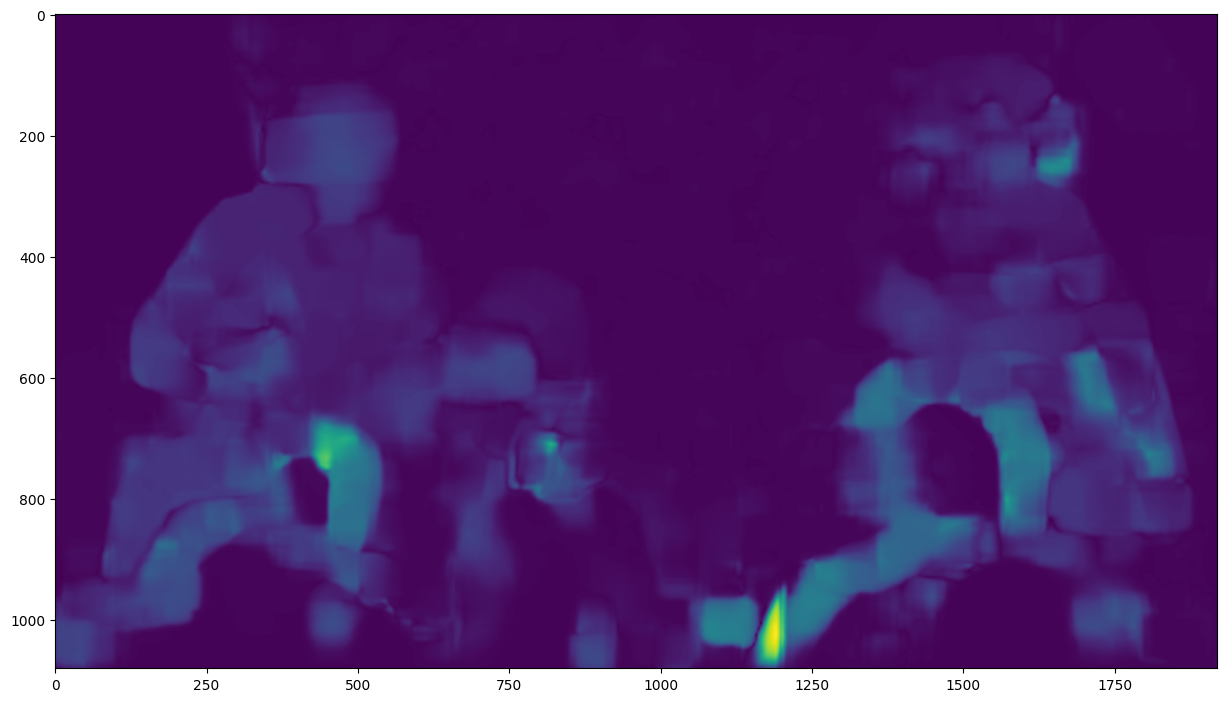

In [ ]:
from tqdm import tqdm
import cv2
import h5py
import pywt

video_idx = 0
#   Read h5 file
LR_h5_file = h5py.File('./vsrnet_test_lrx', 'r')
LR_h5_data = LR_h5_file['data']
LR_Bic_MC_h5_file = h5py.File('./vsrnet_test_lr', 'r')
LR_Bic_MC_h5_data = LR_Bic_MC_h5_file['data']
HR_h5_file = h5py.File('./vsrnet_test_hr', 'r')
HR_h5_data = HR_h5_file['data']
    
# load to memory
HR_h5_data = HR_h5_data[()]#.value
LR_h5_data = LR_h5_data[()]#.value
LR_Bic_MC_h5_data = LR_Bic_MC_h5_data[()]#.value

# transpose to correct order
HR_h5_data = np.transpose(HR_h5_data, (3, 2, 1, 0))
LR_h5_data = np.transpose(LR_h5_data, (3, 2, 1, 0))
LR_Bic_MC_h5_data = np.transpose(LR_Bic_MC_h5_data, (3, 2, 1, 0))

# print(HR_h5_data.shape)
# print(LR_h5_data.shape)
    
frame_number = LR_h5_data.shape[0]
# print(frame_number)

IS_REAL_TIME = False

video_name = 'scene_30'
    
if not IS_REAL_TIME:
    fps = 30
    size = (LR_h5_data.shape[3], LR_h5_data.shape[2])
    output_name = './' + video_name.split('.')[0] + '.avi'
    videoWriter = cv2.VideoWriter(output_name, cv2.VideoWriter_fourcc('M','J','P','G'), fps, size)
#            videoWriter = cv2.VideoWriter(output_name, cv2.VideoWriter_fourcc(*'XVID'), fps, size)
        
#   Prepare to save PSNR and SSIM of the current video
#   Each value corresponding to one test frame
model_PSNR_cur   = np.zeros(frame_number)
model_SSIM_cur   = np.zeros(frame_number)
bicubic_PSNR_cur = np.zeros(frame_number)
bicubic_SSIM_cur = np.zeros(frame_number)
model_time_cur   = np.zeros(frame_number)
    
for idx in tqdm(range(0, 1)):
    img_HR = HR_h5_data[idx, 0, :, :] #2D
    img_LR = LR_h5_data[idx, :, :, :] #3D 5x1080x1920
    img_LR_Bic_MC1 = LR_Bic_MC_h5_data[idx, 1, :, :]
    img_LR_Bic_MC2 = LR_Bic_MC_h5_data[idx, 0, :, :]
    
    # Reshape to 4D
    img_LR = img_LR.reshape((1, img_LR.shape[0], img_LR.shape[1], img_LR.shape[2]))
    img_LR0 = np.squeeze(img_LR[:,2,:,:],axis=0)
    img_LR0 = img_LR0.astype(np.float32)

    img_LR1 = np.squeeze(img_LR[:,1,:,:],axis=0)
    img_LR1 = img_LR1.astype(np.float32)

    # Calculates dense optical flow by Farneback method

    print(img_LR1.shape)

    mask = np.zeros((img_LR0.shape[0],img_LR0.shape[1],3))
    print(mask.shape)
  
    # Sets image saturation to maximum
    mask[..., 1] = 255

    flow = cv2.calcOpticalFlowFarneback(img_LR1, img_LR0, 
                                       None,
                                       0.5, 3, 15, 3, 5, 1.2, 0)
      
    # # Computes the magnitude and angle of the 2D vectors
    magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
      
    # Sets image hue according to the optical flow 
    # direction
    mask[..., 0] = angle * 180 / np.pi / 2
      
    # Sets image value according to the optical flow
    # magnitude (normalized)
    mask[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
      
    # Converts HSV to RGB (BGR) color representation
    # rgb = cv2.cvtColor(mask, cv2.COLOR_HSV2BGR)

    magnitude = cv2.resize(magnitude, (magnitude.shape[1]*4,magnitude.shape[0]*4), interpolation=cv2.INTER_CUBIC)
    magnitude = np.divide(magnitude - np.min(magnitude),(np.max(magnitude) - np.min(magnitude)))
    # print(magnitude.shape)
    # plt.imshow(magnitude)

    start = time.time()
    # if img_LR_Bic_MC.sum() != 0:
    #     img_HR_net = model(img_LR_Bic_MC)
    # else:
    #     img_HR_net = img_LR_Bic_MC[:,2,:,:]
    #     img_HR_net = img_HR_net.reshape((1, 1, img_HR.shape[0], img_HR.shape[1])) # reshape to 1x1x1080x1920
    img_mode = 'L' 
    img_LR0 = cv2.cvtColor(img_LR0, cv2.COLOR_GRAY2RGB) 
    img_LR0 = np.expand_dims(img_LR0, axis=0)
    img_HR_net = model(img_LR0).numpy()
        
    end = time.time() # measure the computation time
   
#     img_HR_net = img_HR_net.cpu()
#     img_HR_net = img_HR_net.data[0].numpy()
#     img_HR_net *= 255.0
    img_HR_net = img_HR_net.clip(0, 255)
    img_HR_net = img_HR_net.astype(np.uint8)
    print(img_HR_net.shape)

    # plt.imshow(img_HR_net[0,:,:,:])
    
#     img_LR_Bic_MC = img_LR_Bic_MC.cpu()
#     img_LR_Bic = img_LR_Bic_MC[:, 2, :, :] # center frame
#     img_LR_Bic = img_LR_Bic.data[0].numpy()
    img_LR_Bic_MC1 *= 255.0
    img_LR_Bic_MC1 = img_LR_Bic_MC1.clip(0, 255)
    img_LR_Bic_MC1 = img_LR_Bic_MC1.astype(np.uint8)
    
#     img_HR = img_HR.reshape((1, img_HR.shape[0], img_HR.shape[1]))
#     img_LR_Bic = img_LR_Bic.reshape((1, img_LR_Bic.shape[0], img_LR_Bic.shape[1]))
    # print(np.max(img_HR_net))

    img_mode = 'L' 
    img_HR = cv2.cvtColor(img_HR, cv2.COLOR_GRAY2RGB)
    img_HR = np.expand_dims(img_HR, axis=0) 

    img_mode = 'L' 
    img_LR_Bic_MC1 = cv2.cvtColor(img_LR_Bic_MC1, cv2.COLOR_GRAY2RGB)
    img_LR_Bic_MC1 = np.expand_dims(img_LR_Bic_MC1, axis=0)

    # img = combined(img_HR_net,img_LR_Bic_MC1)

    print(tf.image.psnr(img_HR,img_LR_Bic_MC1, max_val=255))
    print(tf.image.psnr(img_HR,img_HR_net, max_val=255))

    img_HR_net = np.squeeze(img_HR_net,axis=0)
    img_LR_Bic_MC1 = np.squeeze(img_LR_Bic_MC1,axis=0)

    # fused_img_r = fusion(img_HR_net[:,:,0], img_LR_Bic_MC1[:,:,0])
    # fused_img_g = fusion(img_HR_net[:,:,1], img_LR_Bic_MC1[:,:,1])
    # fused_img_b = fusion(img_HR_net[:,:,2], img_LR_Bic_MC1[:,:,2]) 
    # fused_img = np.stack([fused_img_r, fused_img_g, fused_img_b] ,axis=2)

    fused_img = fusion(img_HR_net, img_LR_Bic_MC1)
    # plt.imshow(fused_img)
    magnitude = np.expand_dims(magnitude, axis=2)
    magnitude = np.repeat(magnitude, 3, axis=2)
    combined = np.multiply((1-magnitude),img_HR_net)+np.multiply(magnitude,img_LR_Bic_MC1)
    # combined1 = 0.1*img_LR_Bic_MC1 + 0.9*img_HR_net
    combined = np.expand_dims(combined, axis=0)
    # combined1 = np.expand_dims(combined1, axis=0)
    
    print(combined.shape)
    combined = combined.astype(np.uint8)
    # combined1 = combined1.astype(np.uint8)
    print(tf.image.psnr(img_HR, combined, max_val=255))
    # print(tf.image.psnr(img_HR, combined1, max_val=255))
    
#     model_PSNR_cur[idx]   = psnr((img_HR).reshape(img_HR.shape[1], img_HR.shape[2]).astype(int), (img_HR_net).reshape(img_HR_net.shape[1], img_HR_net.shape[2]).astype(int))
#     model_SSIM_cur[idx]   = ssim((img_HR).reshape(img_HR.shape[1], img_HR.shape[2]).astype(int), (img_HR_net).reshape(img_HR_net.shape[1], img_HR_net.shape[2]).astype(int))
#     bicubic_PSNR_cur[idx] = psnr((img_HR).reshape(img_HR.shape[1], img_HR.shape[2]).astype(int), (img_LR_Bic).reshape(img_LR_Bic.shape[1], img_LR_Bic.shape[2]).astype(int))
#     bicubic_SSIM_cur[idx] = ssim((img_HR).reshape(img_HR.shape[1], img_HR.shape[2]).astype(int), (img_LR_Bic).reshape(img_LR_Bic.shape[1], img_LR_Bic.shape[2]).astype(int))
#     model_time_cur[idx]   = (end-start)

#     # Repeat to 3 channels to save and display
#     img_HR_net = np.repeat(img_HR_net, 3, axis=0)
#     img_HR_net = np.transpose(img_HR_net, (1, 2, 0))

#     if IS_REAL_TIME:
#         plt.imshow(img_HR_net, cmap = 'gray')
#         plt.show()

# #                cv2.imshow('LR Video ', img_LR_Bic)
# #                cv2.imshow('SR Video ', img_HR_net)
# #                cv2.waitKey(DELAY_TIME)
#     else:
#         # save video
#         videoWriter.write(img_HR_net)
    
# # Done video writing
# videoWriter.release()

# # Save PSNR and SSIM
# # Exclude PSNR = 100 cases (caused by black frames)
# cal_flag = (model_PSNR_cur != 100)
# model_PSNR[video_idx]   = np.mean(model_PSNR_cur[cal_flag])
# model_SSIM[video_idx]   = np.mean(model_SSIM_cur[cal_flag])
# bicubic_PSNR[video_idx] = np.mean(bicubic_PSNR_cur[cal_flag])
# bicubic_SSIM[video_idx] = np.mean(bicubic_SSIM_cur[cal_flag])
# model_time[video_idx]   = np.mean(model_time_cur[cal_flag])

# print("===> Test on Video Idx: " + str(video_idx) +" Complete: Model PSNR: {:.4f} dB, Model SSIM: {:.4f} , Bicubic PSNR:  {:.4f} dB, Bicubic SSIM: {:.4f} , Average time: {:.4f}"
#   .format(model_PSNR[video_idx], model_SSIM[video_idx], bicubic_PSNR[video_idx], bicubic_SSIM[video_idx], model_time[video_idx]*1000))
# video_idx += 1